<a href="https://colab.research.google.com/github/Tatpon007/ai-frame/blob/main/ai_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
df_test = pd.read_csv("/content/drive/MyDrive/2024-flame-ai-challenge/dataset/test.csv")
df_train = pd.read_csv("/content/drive/MyDrive/2024-flame-ai-challenge/dataset/train.csv")
df_test

,id,u,alpha,Nt,Nx,Ny,theta_filename,ustar_filename,xi_filename
0,219547,5,2.5,5,113,32,theta_K_id219547.dat,ustar_ms-1_id219547.dat,xi_id219547.dat
1,167403,5,2.5,5,113,32,theta_K_id167403.dat,ustar_ms-1_id167403.dat,xi_id167403.dat
2,225258,5,2.5,5,113,32,theta_K_id225258.dat,ustar_ms-1_id225258.dat,xi_id225258.dat
3,890407,5,25.0,5,113,32,theta_K_id890407.dat,ustar_ms-1_id890407.dat,xi_id890407.dat
4,352206,5,25.0,5,113,32,theta_K_id352206.dat,ustar_ms-1_id352206.dat,xi_id352206.dat
5,989981,5,25.0,5,113,32,theta_K_id989981.dat,ustar_ms-1_id989981.dat,xi_id989981.dat
6,714528,5,7.5,5,113,32,theta_K_id714528.dat,ustar_ms-1_id714528.dat,xi_id714528.dat
7,769043,5,7.5,5,113,32,theta_K_id769043.dat,ustar_ms-1_id769043.dat,xi_id769043.dat
8,965687,5,7.5,5,113,32,theta_K_id965687.dat,ustar_ms-1_id965687.dat,xi_id965687.dat
9,329500,9,2.5,5,113,32,theta_K_id329500.dat,ustar_ms-1_id329500.dat,xi_id329500.dat


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, GRU, TimeDistributed, Conv2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os

# Function to load the data and combine ustar, theta, and xi
def train_det_to_array(df, path_file):
    dimension = len(df)
    X, Y = [], []

    for i in range(dimension):
        Nt, Nx, Ny = df["Nt"][i], df["Nx"][i], df["Ny"][i]
        path_before_file = path_file

        # Load theta, ustar, and xi arrays from file
        theta_array = np.fromfile(os.path.join(path_before_file, df["theta_filename"][i]), dtype="<f4").reshape(Nt, Nx, Ny)
        ustar_array = np.fromfile(os.path.join(path_before_file, df["ustar_filename"][i]), dtype="<f4").reshape(Nt, Nx, Ny)
        xi_array = np.fromfile(os.path.join(path_before_file, df["xi_filename"][i]), dtype="<f4").reshape(Nt, Nx, Ny)

        # Stack ustar and theta for X, and use xi for Y
        X.append(np.stack([ustar_array, theta_array], axis=-1))  # Shape: (Nt, Nx, Ny, 2)
        Y.append(xi_array)  # Shape: (Nt, Nx, Ny)

    # Convert lists to numpy arrays
    X = np.concatenate(X)  # Combine along time dimension
    Y = np.concatenate(Y)

    return X, Y

def test_det_to_array(df, path_file):
    dimension = len(df)
    X, Y = [], []
    Nt, Nx, Ny = df["Nt"][0], df["Nx"][0], df["Ny"][0]
    theta_array = np.fromfile(os.path.join(path_file, df["theta_filename"][0]), dtype="<f4").reshape(Nt, Nx, Ny)
    ustar_array = np.fromfile(os.path.join(path_file, df["ustar_filename"][0]), dtype="<f4").reshape(Nt, Nx, Ny)
    xi_array = np.fromfile(os.path.join(path_file, df["xi_filename"][0]), dtype="<f4").reshape(Nt, Nx, Ny)

        # Stack ustar and theta for X, and use xi for Y
    X.append(np.stack([ustar_array, theta_array], axis=-1))  # Shape: (Nt, Nx, Ny, 2)
    Y.append(xi_array)  # Shape: (Nt, Nx, Ny)
    for i in range(dimension):
        Nt, Nx, Ny = df["Nt"][i], df["Nx"][i], df["Ny"][i]
        path_before_file = path_file

        # Load theta, ustar, and xi arrays from file
        theta_array = np.fromfile(os.path.join(path_before_file, df["theta_filename"][i]), dtype="<f4").reshape(Nt, Nx, Ny)
        ustar_array = np.fromfile(os.path.join(path_before_file, df["ustar_filename"][i]), dtype="<f4").reshape(Nt, Nx, Ny)
        xi_array = np.fromfile(os.path.join(path_before_file, df["xi_filename"][i]), dtype="<f4").reshape(Nt, Nx, Ny)

        # Stack ustar and theta for X, and use xi for Y
        X.append(np.stack([ustar_array, theta_array], axis=-1))  # Shape: (Nt, Nx, Ny, 2)
        Y.append(xi_array)  # Shape: (Nt, Nx, Ny)

    # Convert lists to numpy arrays
    X = np.concatenate(X)  # Combine along time dimension
    Y = np.concatenate(Y)

    return X, Y
# Function to generate sequences
def gen_seq(data_x, data_y, timesteps):
    X_seq, Y_seq = [], []

    # Generate sequences of length 'timesteps'
    for i in range(len(data_x) - timesteps):
        X_seq.append(data_x[i:i + timesteps])  # Sequence from data_x
        Y_seq.append(data_y[i + timesteps])    # Corresponding value from data_y

    return np.array(X_seq), np.array(Y_seq)

# Example usage
time_step = 5

# Load data
train_X, train_Y = train_det_to_array(df_train, "/content/drive/MyDrive/2024-flame-ai-challenge/dataset/train/")
test_X, test_Y = test_det_to_array(df_test, "/content/drive/MyDrive/2024-flame-ai-challenge/dataset/test/")

# Generate sequences
train_X, train_Y = gen_seq(train_X, train_Y, time_step)
test_X, test_Y = gen_seq(test_X, test_Y, time_step)

# Print the shapes to verify
print("train_X shape:", train_X.shape)  # Expected shape: (num_samples, time_steps, Nx, Ny, 2)
print("train_Y shape:", train_Y.shape)  # Expected shape: (num_samples, Nx, Ny)

# Scale input data channel-wise for X data
def scale_channels_X(data, scaler=None):
    # Reshape each channel for scaling
    samples, timesteps, Nx, Ny, channels = data.shape
    scaled_data = data.reshape(-1, channels)  # Shape: (samples * timesteps * Nx * Ny, channels)

    if scaler is None:
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(scaled_data)
    else:
        scaled_data = scaler.transform(scaled_data)

    return scaled_data.reshape(samples, timesteps, Nx, Ny, channels), scaler

# Scale X data
train_X_scaled, scaler_X = scale_channels_X(train_X)
test_X_scaled, _ = scale_channels_X(test_X, scaler=scaler_X)

# Scale Y data (2D scaling)
scaler_Y = MinMaxScaler()
train_Y_scaled = scaler_Y.fit_transform(train_Y.reshape(-1, 1)).reshape(train_Y.shape)
test_Y_scaled = scaler_Y.transform(test_Y.reshape(-1, 1)).reshape(test_Y.shape)

print("Scaled train_X shape:", train_X_scaled.shape)
print("Scaled train_Y shape:", test_Y_scaled.shape)


train_X shape: (1345, 5, 113, 32, 2)
train_Y shape: (1345, 113, 32)
Scaled train_X shape: (1345, 5, 113, 32, 2)
Scaled train_Y shape: (135, 113, 32)


In [ ]:
from tensorflow.keras.layers import LSTM, TimeDistributed, Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Reshape, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

# Adjusted optimizer with lower learning rate for smoother convergence
optimizer = Adam(learning_rate=0.0001)  # Further reduced learning rate for stability
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Moderate patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Learning rate scheduler

# Model definition with increased complexity
model = Sequential([
    Input(shape=(5, 113, 32, 2)),  # Input shape: 5 time steps, 113x32 spatial grid, 2 channels (ustar, theta)

    # First Conv2D layer with more filters
    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),

    # Second Conv2D layer
    TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),

    # Apply Global Average Pooling for each time step
    TimeDistributed(GlobalAveragePooling2D()),

    Dropout(0.3),  # Adjusted dropout rate for better regularization

    # Flatten the output after pooling
    TimeDistributed(Flatten()),

    # Apply LSTM layer with more units
    LSTM(128, activation='tanh', return_sequences=False),  # Increased units for capturing more complexity

    # Dense layer with increased units
    Dense(512, activation='relu'),  # Increased Dense layer capacity

    # Output layer for regression (no activation function, regression task)
    Dense(113 * 32),  # No activation for regression task

    Reshape((113, 32))  # Reshaping the output to match the required spatial shape
])

# Compile the model with mean squared error loss for regression
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 5, 113, 32, 32)      │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 5, 113, 32, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 5, 113, 32, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 5, 113, 32, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3616)                │       1,855,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 113, 32)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,039,360 (7.78 MB)

 Trainable params: 2,039,168 (7.78 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model5 = model

In [ ]:
hist_50 = model.fit(train_X_scaled, train_Y_scaled, epochs=30, batch_size=64,
                 validation_data=(train_X_scaled, train_Y_scaled),
                 callbacks=[early_stopping, reduce_lr])



Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - loss: 0.0262 - mae: 0.0478 - val_loss: 0.0250 - val_mae: 0.0303 - learning_rate: 1.0000e-04
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0243 - mae: 0.0391 - val_loss: 0.0242 - val_mae: 0.0365 - learning_rate: 1.0000e-04
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0234 - mae: 0.0431 - val_loss: 0.0228 - val_mae: 0.0456 - learning_rate: 1.0000e-04
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0218 - mae: 0.0472 - val_loss: 0.0223 - val_mae: 0.0502 - learning_rate: 1.0000e-04
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0213 - mae: 0.0463 - val_loss: 0.0215 - val_mae: 0.0495 - learning_rate: 1.0000e-04
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0209 - mae: 0.0461 - val_loss: 0.0208 - val_mae: 0.0474 - learning_rate: 1.0000e-04
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0208 - mae: 0.0467 - val_loss: 0.0203 - val_mae: 0.0476 - lea

In [ ]:
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model # Import the load_model function

# Save the model
model.save('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')

# Load the model
model = load_model('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')  # Correct path

In [ ]:
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model # Import the load_model function

# Save the model
model.save('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')

# Load the model
model = load_model('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')  # Correct path

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
R² score: -0.0083


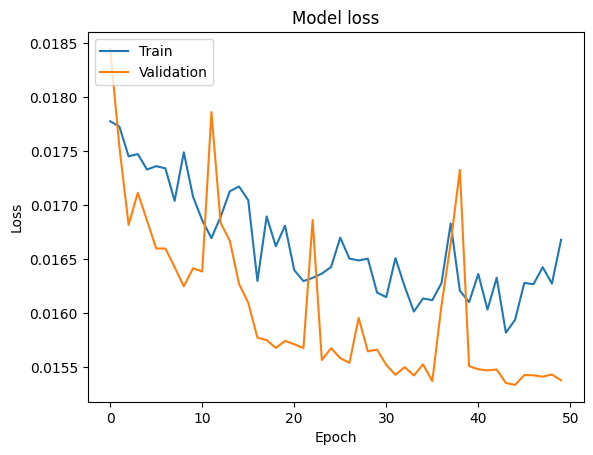

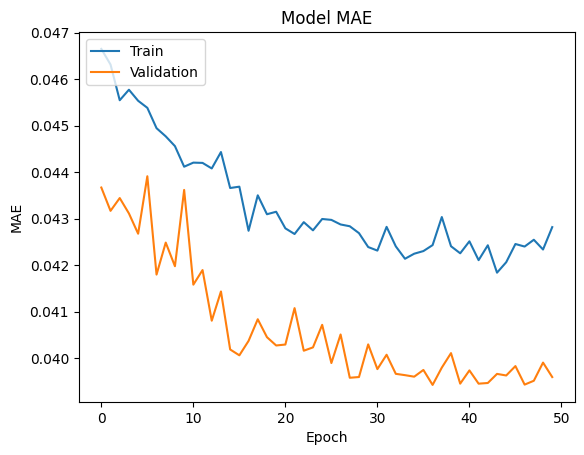

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


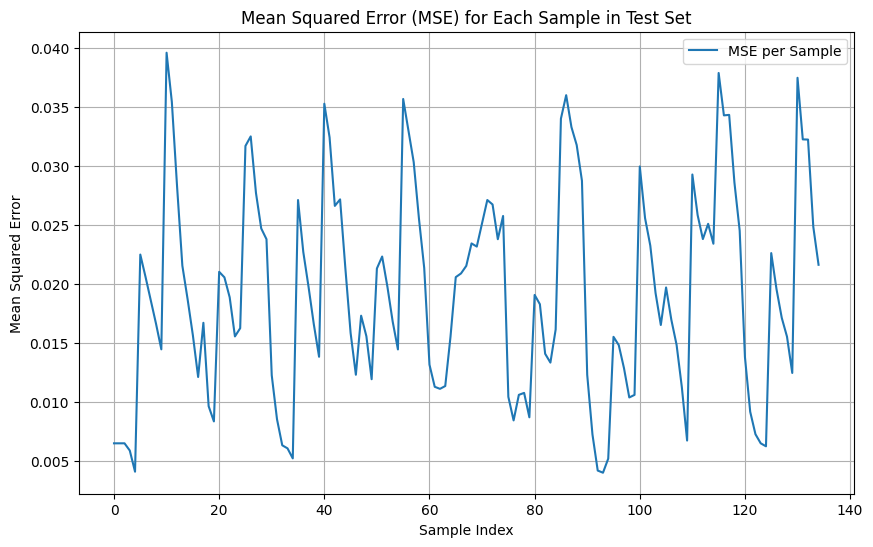

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Evaluate the model on the test set
y_pred = model.predict(test_X_scaled)

# Calculate R² score
r2 = r2_score(test_Y_scaled.flatten(), y_pred.flatten())  # Flatten to 1D if needed
print(f"R² score: {r2:.4f}")

# Plot training & validation loss values
plt.plot(hist_50.history['loss'])
plt.plot(hist_50.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(hist_50.history['mae'])
plt.plot(hist_50.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming you have test predictions and true labels
test_predictions = model.predict(test_X_scaled)

# Calculate MSE for each sample
mse_per_sample = [
    mean_squared_error(test_Y_scaled[i].flatten(), test_predictions[i].flatten())
    for i in range(len(test_Y_scaled))
]

# Plot MSE per sample
plt.figure(figsize=(10, 6))
plt.plot(mse_per_sample, label='MSE per Sample')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error (MSE) for Each Sample in Test Set')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio  # For creating GIFs
from sklearn.metrics import mean_squared_error

# Assuming you've already made predictions

test_predictions = model.predict(test_X_scaled)

# Threshold the predictions to get binary values (0 or 1)
scaler = MinMaxScaler(feature_range=(0, 1))
test_predictions = scaler.fit_transform(test_predictions.reshape(-1, 1)).reshape(135, 113, 32)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Flatten both the true values (Y_test_scaled) and the predicted values
Y_test_flattened = test_Y_scaled.reshape(-1)  # Flatten true values
test_predictions_flattened = test_predictions_binary.reshape(-1)  # Flatten predicted values

# Now calculate the Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_flattened, test_predictions_flattened)

# Print the result
print(f'Mean Squared Error (MSE) on Test Set: {mse}')

# Create frames for the GIF
gif_frames = []

for i in range(30):  # Change this to visualize more samples
    # Create a new figure for each sample
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot actual values (ground truth) for the i-th sample
    axes[0].imshow(test_Y_scaled[i], cmap='viridis')  # Actual values for the i-th sample
    axes[0].set_title(f'True Values (Sample {i})')
    axes[0].axis('off')  # Hide axes
    fig.colorbar(axes[0].imshow(test_Y_scaled[i], cmap='viridis'), ax=axes[0])

    # Plot predicted values for the i-th sample
    axes[1].imshow(test_predictions_binary[i], cmap='viridis')  # Predicted values for the i-th sample
    axes[1].set_title(f'Predicted Values (Sample {i})')
    axes[1].axis('off')  # Hide axes
    fig.colorbar(axes[1].imshow(test_predictions_binary[i], cmap='viridis'), ax=axes[1])

    # Save each frame to the frames list
    temp_filename = f"temp_frame_{i}.png"
    plt.savefig(temp_filename)
    plt.close(fig)

    # Append image to the gif frames list
    gif_frames.append(imageio.imread(temp_filename))

    # Clean up temp file after loading it into memory
    os.remove(temp_filename)

# Create the GIF
output_gif_path = 'test_visualization.gif'  # Save to current directory
imageio.mimsave(output_gif_path, gif_frames, duration=0.5)  # Adjust duration as needed
print(f"GIF saved at {output_gif_path}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
Mean Squared Error (MSE) on Test Set: 0.02691740412979351
GIF saved at test_visualization.gif


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Mean Squared Error (MSE) on Test Set: 0.047457800721075055


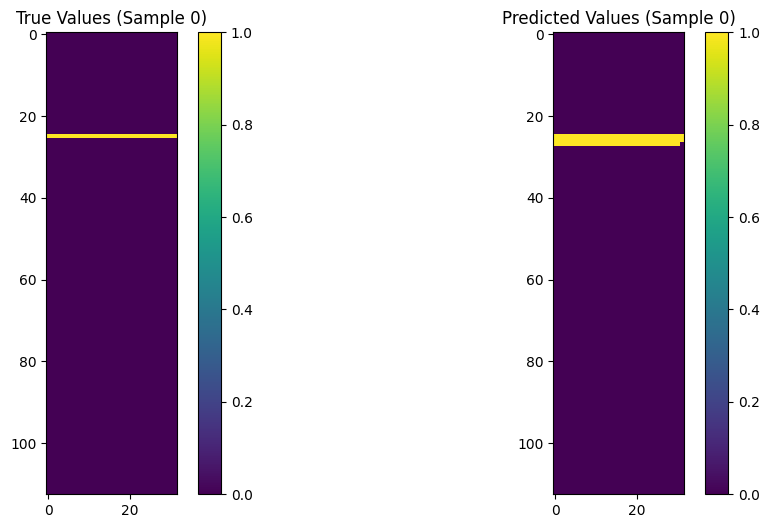

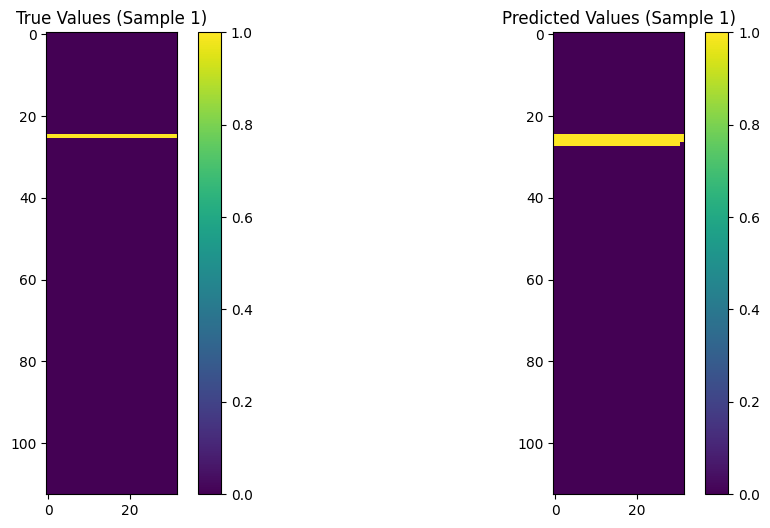

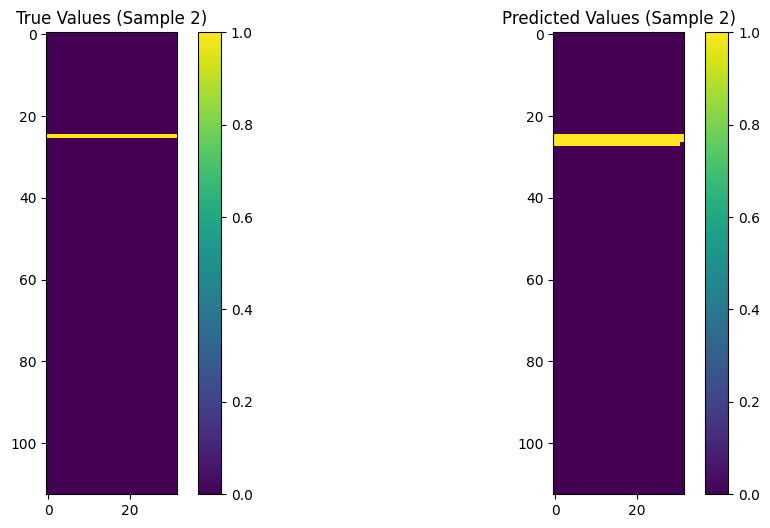

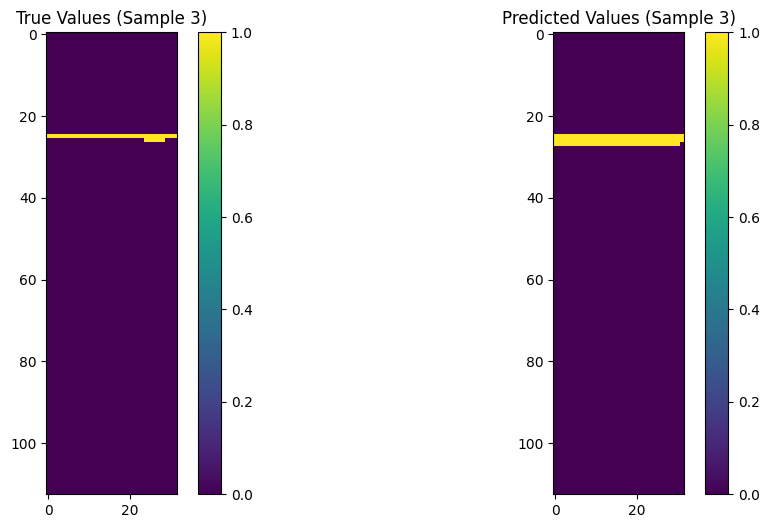

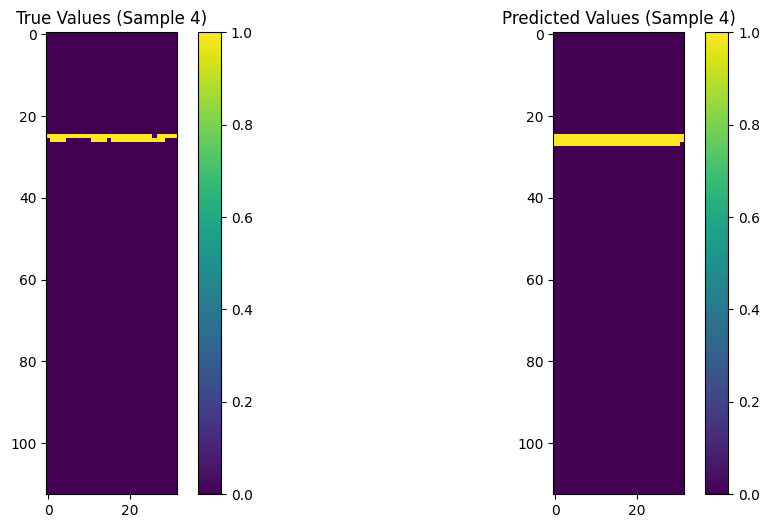

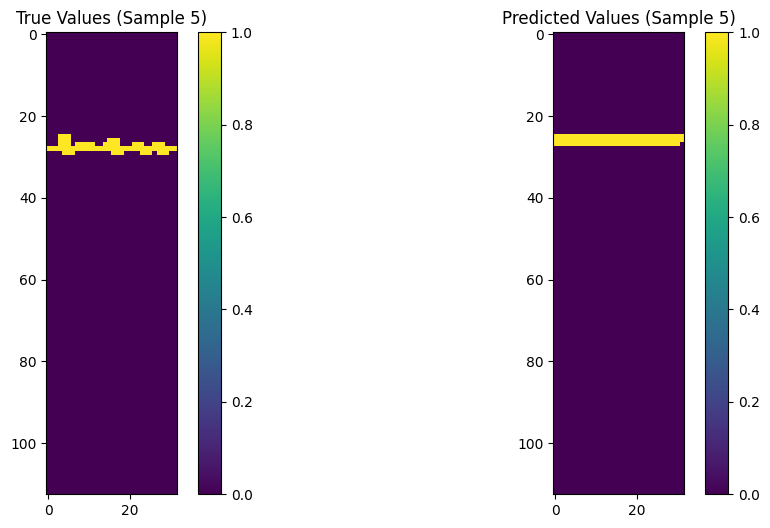

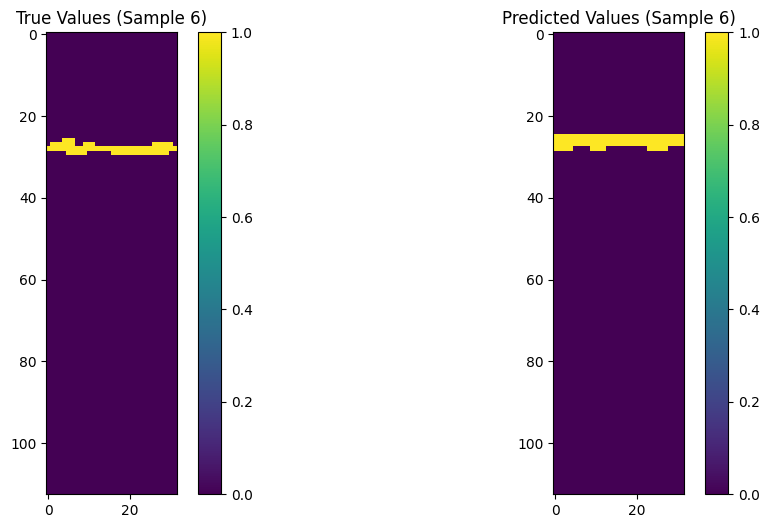

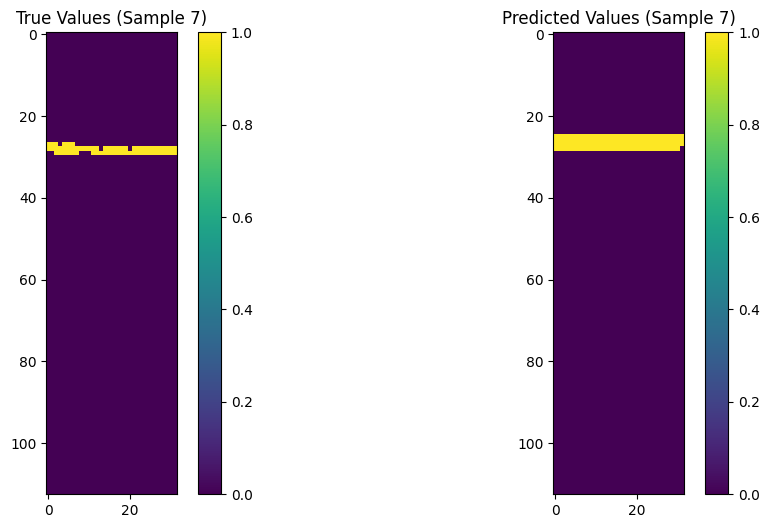

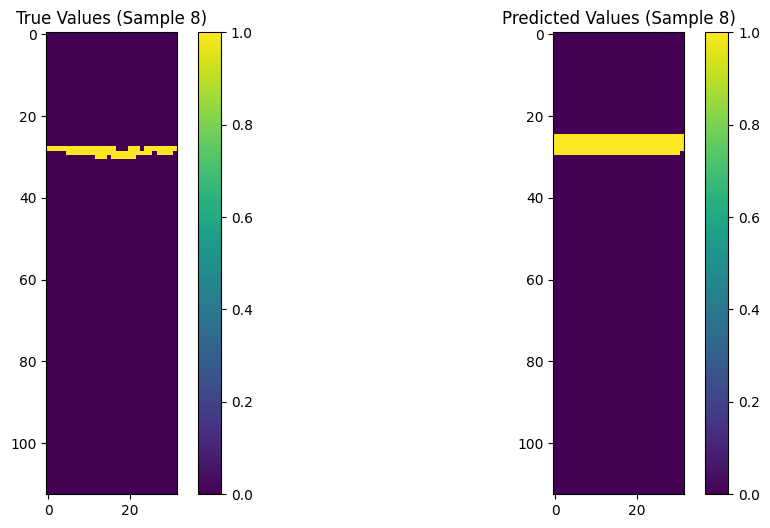

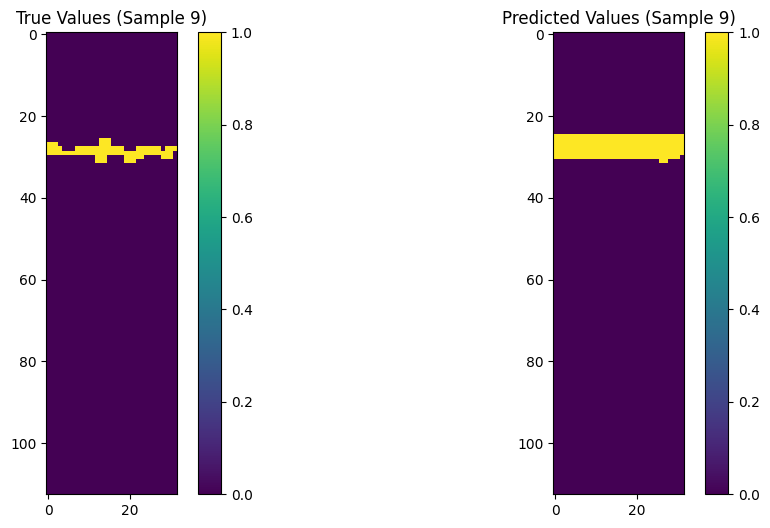

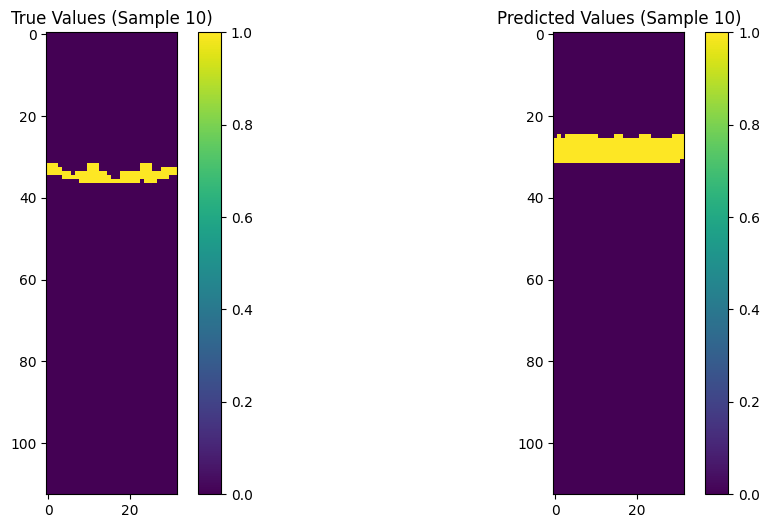

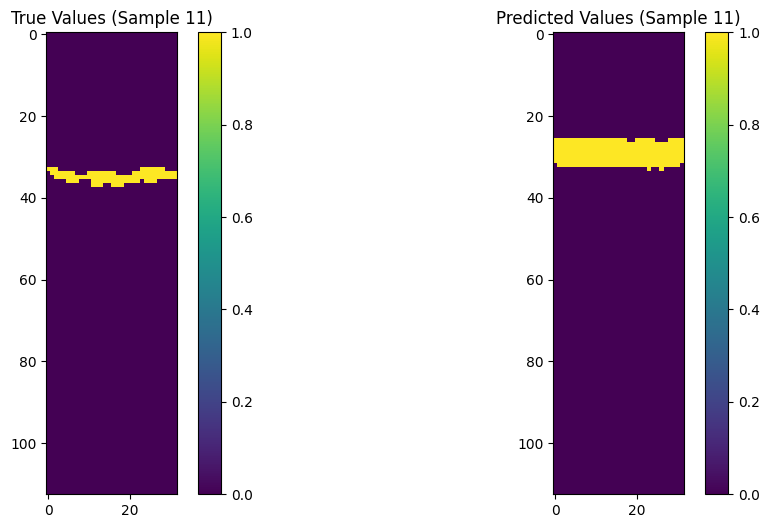

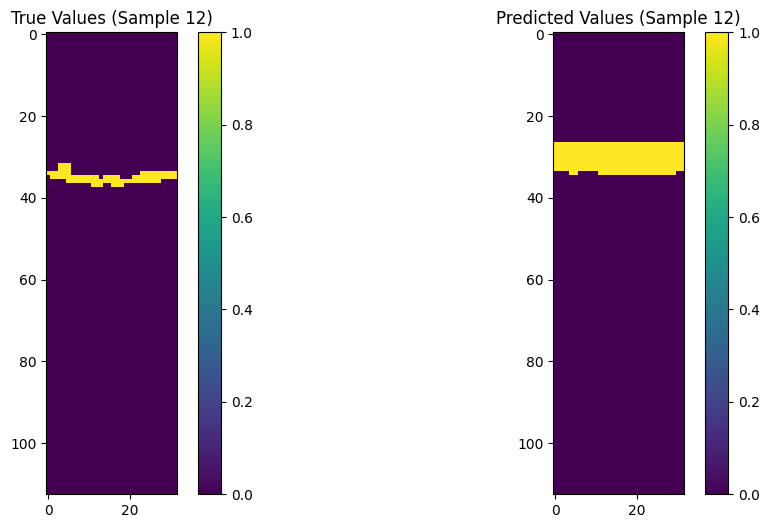

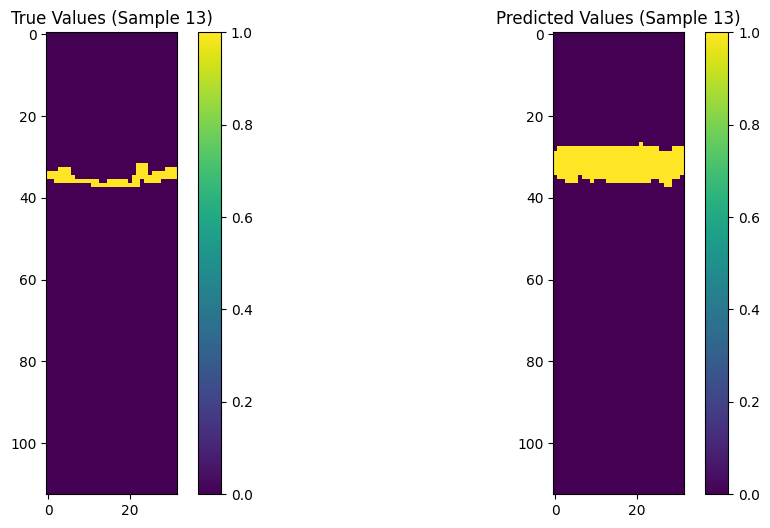

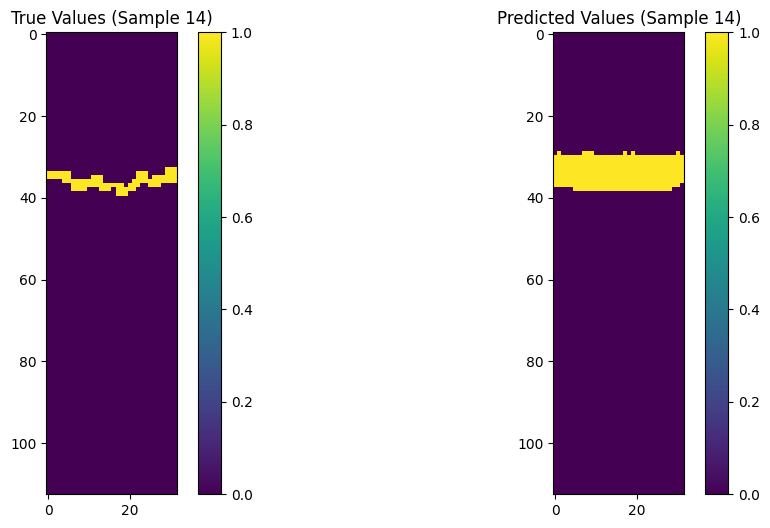

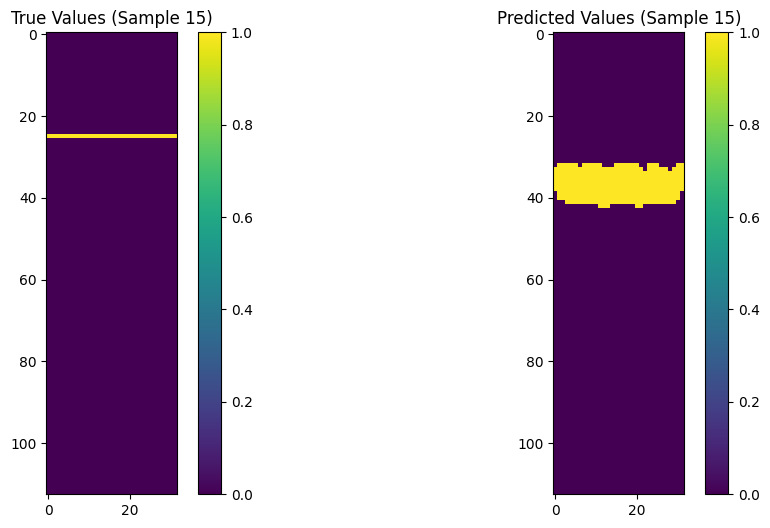

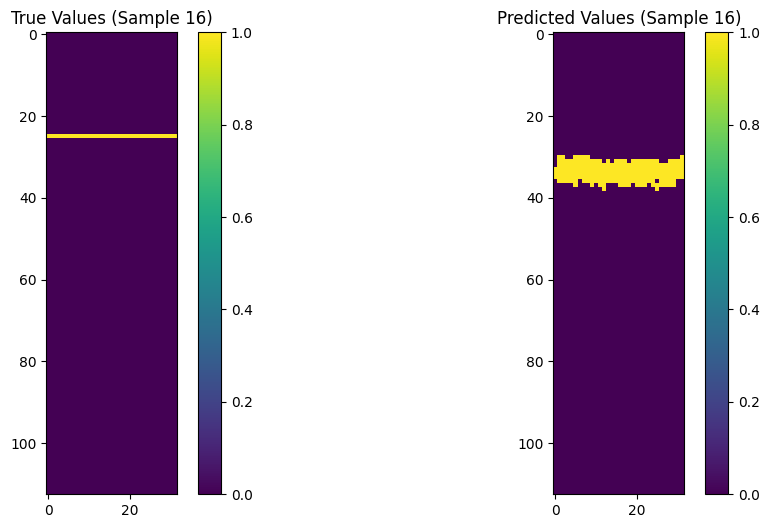

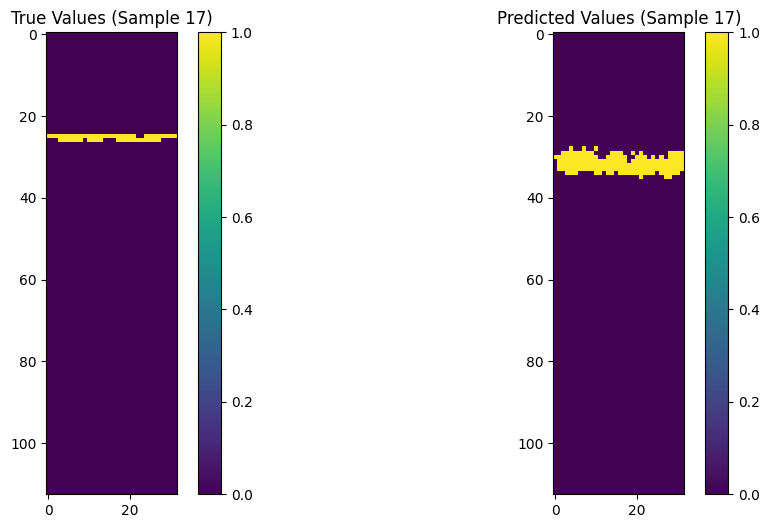

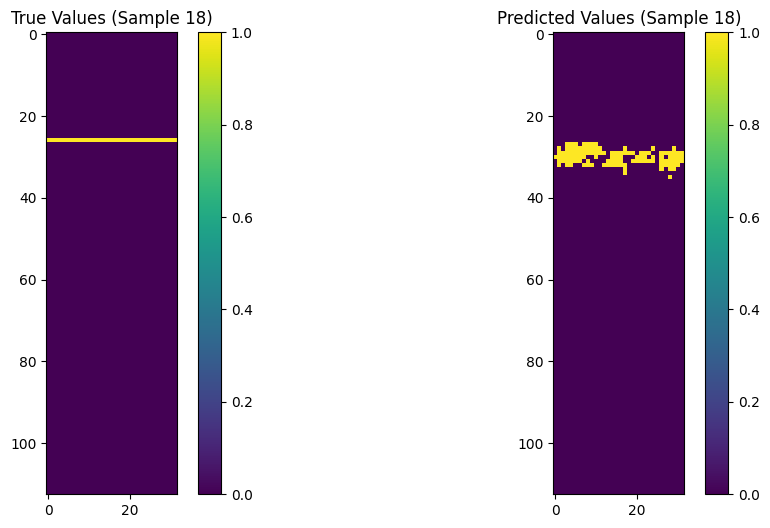

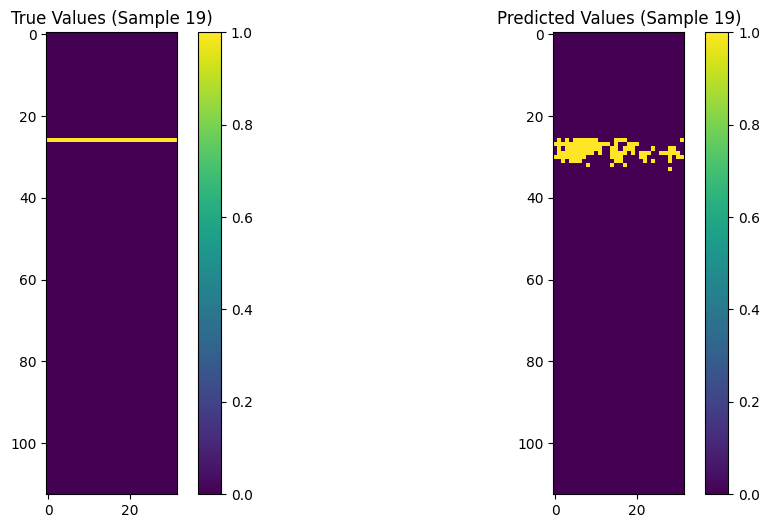

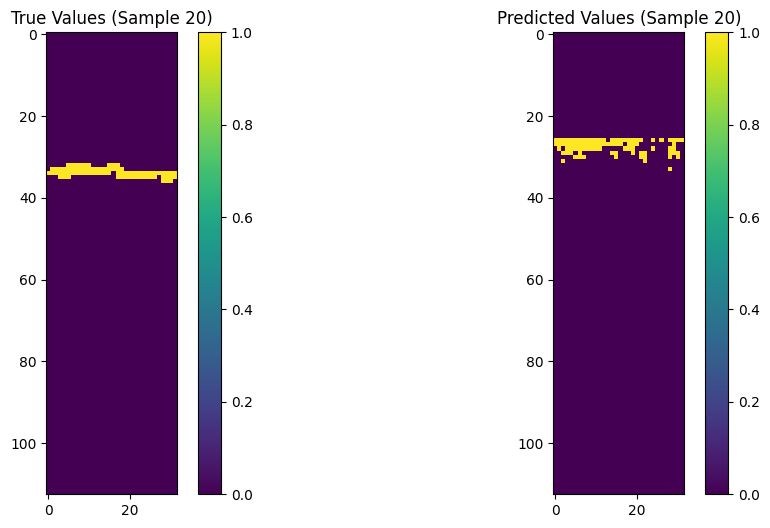

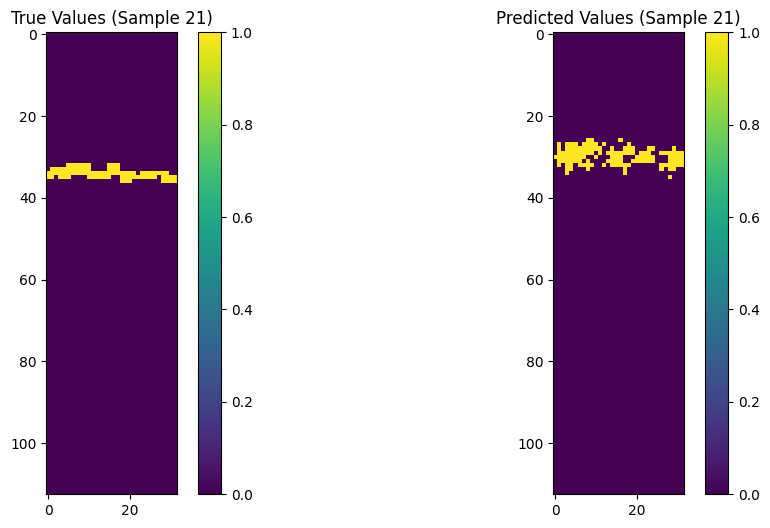

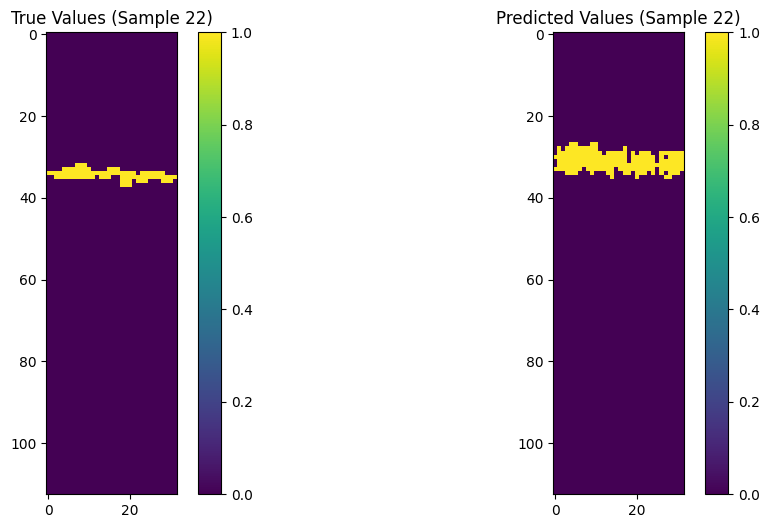

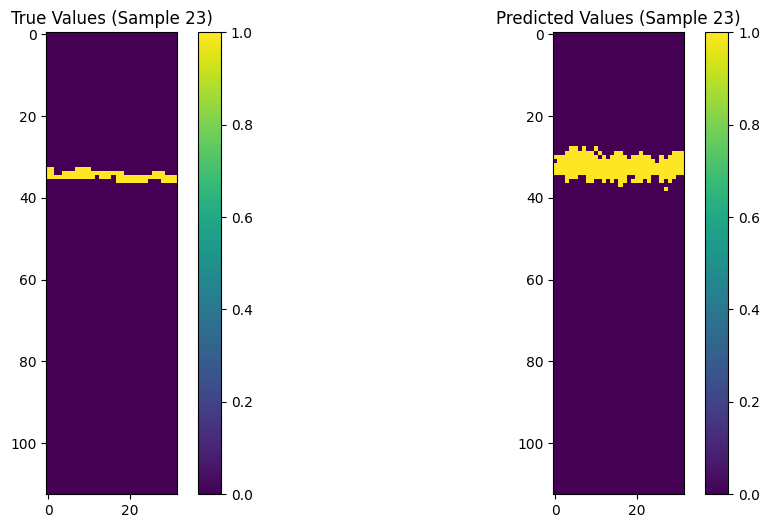

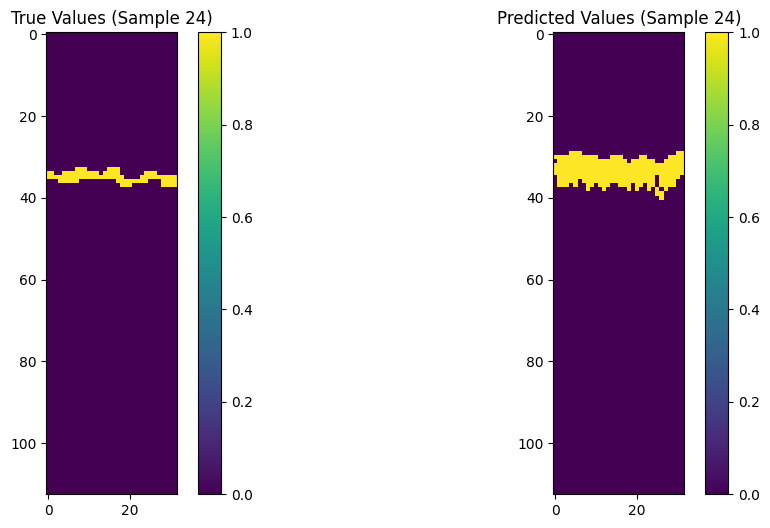

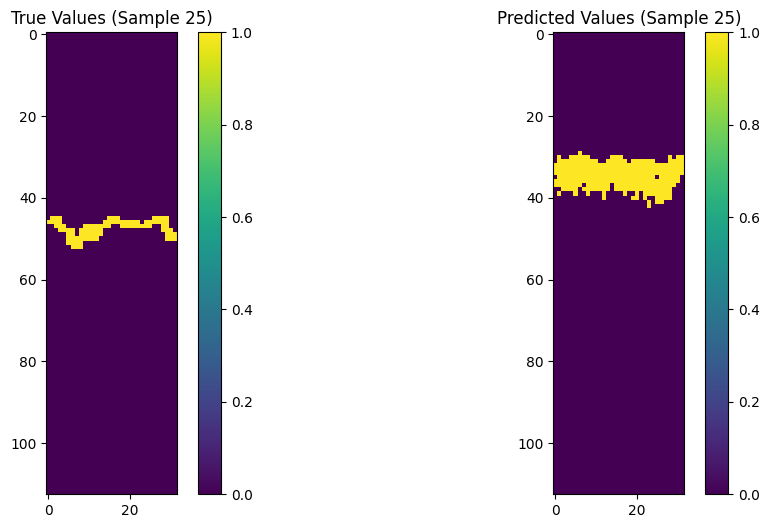

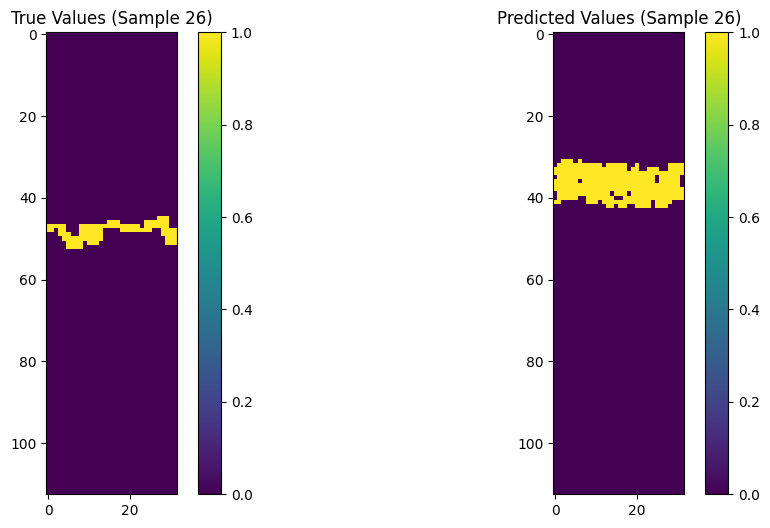

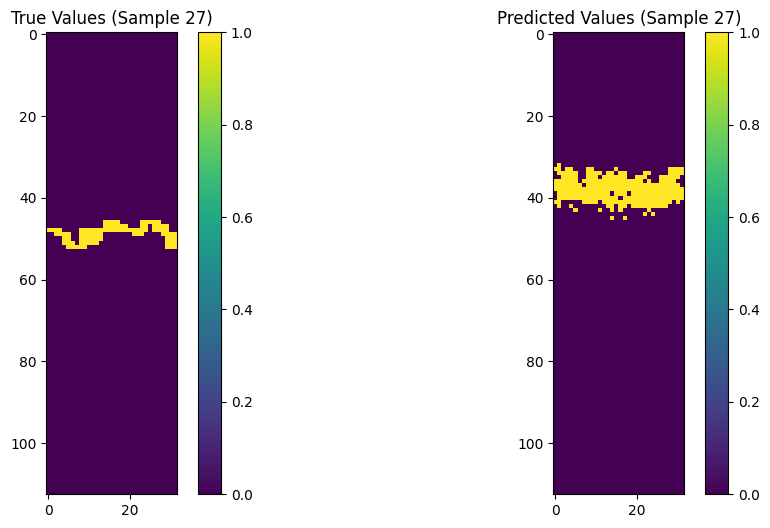

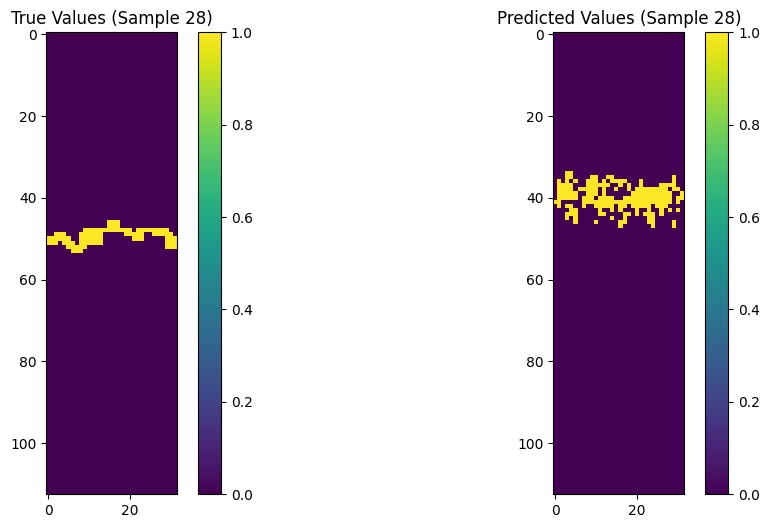

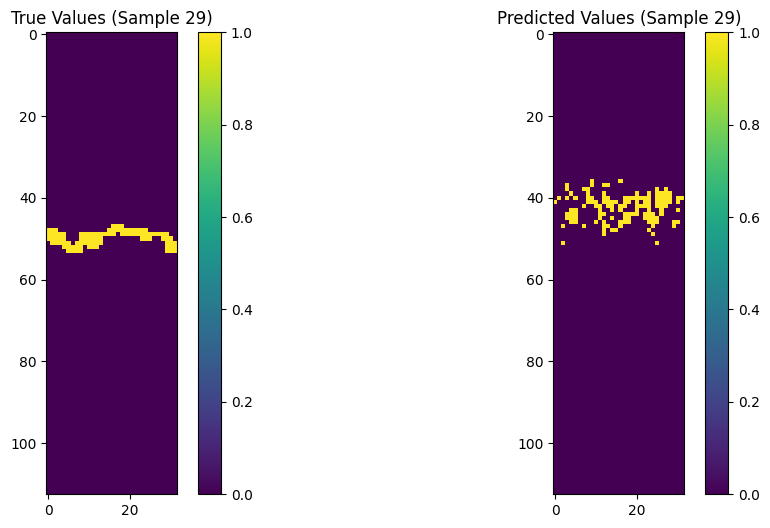

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')
test_predictions = model.predict(test_X_scaled)
scaler = MinMaxScaler(feature_range=(0, 1))
test_predictions = scaler.fit_transform(test_predictions.reshape(-1, 1)).reshape(135, 113, 32)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Threshold the predictions to get binary values (0 or 1)
test_predictions_binary = (test_predictions > 0.3).astype(int)

# Flatten both the true values (Y_test_scaled) and the predicted values
Y_test_flattened = test_Y_scaled.reshape(-1)  # Flatten true values
test_predictions_flattened = test_predictions_binary.reshape(-1)  # Flatten predicted values

# Now calculate the Mean Squared Error (MSE)
mse = mean_squared_error(Y_test_flattened, test_predictions_flattened)

# Print the result
print(f'Mean Squared Error (MSE) on Test Set: {mse}')

# Plotting the first sample of predictions vs actual values
for i in range(30):  # You can change this to visualize more samples
    plt.figure(figsize=(12, 6))

    # Plot actual values (ground truth) for the i-th sample
    plt.subplot(1, 2, 1)
    plt.imshow(test_Y_scaled[i], cmap='viridis')  # Actual values for the i-th sample
    plt.title(f'True Values (Sample {i})')
    plt.colorbar()

    # Plot predicted values for the i-th sample
    plt.subplot(1, 2, 2)
    plt.imshow(test_predictions_binary[i], cmap='viridis')  # Predicted values for the i-th sample
    plt.title(f'Predicted Values (Sample {i})')
    plt.colorbar()

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio  # For creating GIFs
from sklearn.metrics import mean_squared_error
def create_binary_gif(frames, output_gif_path, duration=0.2):
    gif_frames = []

    for i, frame_data in enumerate(frames):
        plt.figure(figsize=(6, 6))
        plt.imshow(frame_data, cmap='binary', interpolation='nearest')
        plt.title(f'Frame {i}')
        plt.axis('off')

        # Save to temporary frame
        temp_filename = f"temp_frame_{i}.png"
        plt.savefig(temp_filename)
        plt.close()

        # Append image to the gif frames list
        gif_frames.append(imageio.imread(temp_filename))

        # Clean up temp file after loading it into memory
        os.remove(temp_filename)

    # Create GIF
    imageio.mimsave(output_gif_path, gif_frames, duration=duration)
    print(f"GIF saved at {output_gif_path}")

# Example usage with random binary data
binary_frames = [np.random.choice([0, 1], size=(10, 10)) for _ in range(5)]  # List of binary frames
create_binary_gif(binary_frames, 'binary_data.gif')

GIF saved at binary_data.gif


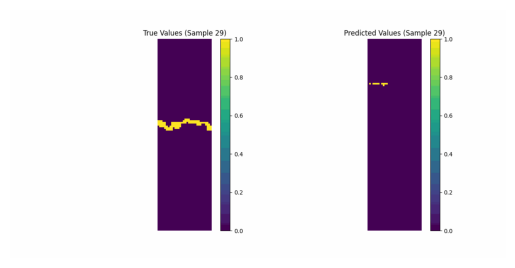

In [ ]:
!pip install Pillow  # Install Pillow if not already installed

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML


img = Image.open("test_visualization.gif")
# Extract all frames from the GIF
frames = []
try:
    while True:
        frames.append(img.copy())
        img.seek(img.tell() + 1)
except EOFError:
    pass

# Create the animation using FuncAnimation
fig = plt.figure()
im = plt.imshow(frames[0], animated=True)

def updatefig(i):
    im.set_array(frames[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=len(frames),
                              interval=50, blit=True)  # Adjust interval as needed
plt.axis("off")
# Convert the animation to HTML for display in Colab
HTML(ani.to_html5_video())

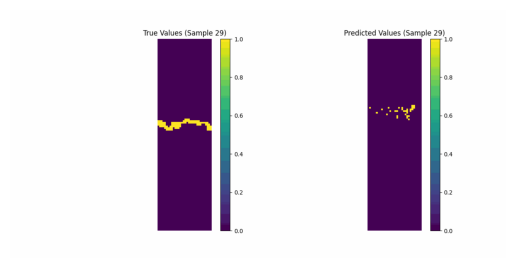

In [ ]:
!pip install Pillow  # Install Pillow if not already installed

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML


img = Image.open("test_visualization.gif")
# Extract all frames from the GIF
frames = []
try:
    while True:
        frames.append(img.copy())
        img.seek(img.tell() + 1)
except EOFError:
    pass

# Create the animation using FuncAnimation
fig = plt.figure()
im = plt.imshow(frames[0], animated=True)

def updatefig(i):
    im.set_array(frames[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=len(frames),
                              interval=50, blit=True)  # Adjust interval as needed
plt.axis("off")
# Convert the animation to HTML for display in Colab
HTML(ani.to_html5_video())

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 7.9 MB/s eta 0:00:00


In [ ]:
!npm install -g localtunnel


added 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
!npm audit fix --force

npm WARN using --force Recommended protections disabled.
npm ERR! code ENOLOCK
npm ERR! audit This command requires an existing lockfile.
npm ERR! audit Try creating one first with: npm i --package-lock-only
npm ERR! audit Original error: loadVirtual requires existing shrinkwrap file

npm ERR! A complete log of this run can be found in:
npm ERR!     /root/.npm/_logs/2024-11-07T05_34_53_351Z-debug-0.log


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tempfile
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

def split_data(df1, df2, num_frames):
    """Reshapes and slices dataframes for processing, with first 5 frames prepended."""
    # Reshape each dataset to (num_frames, 113, 32)
    df1 = df1[:num_frames * 113 * 32].reshape(num_frames, 113, 32)
    df2 = df2[:num_frames * 113 * 32].reshape(num_frames, 113, 32)

    # Get the first 5 frames from each dataset
    f1_first5 = df1[:5, :, :]  # First 5 frames of df1
    f2_first5 = df2[:5, :, :]  # First 5 frames of df2

    # Concatenate first 5 frames to the beginning of each dataset
    df1_full = np.concatenate([f1_first5, df1], axis=0)
    df2_full = np.concatenate([f2_first5, df2], axis=0)

    # Stack df1 and df2 along the last dimension to create a 2-channel array
    df_stacked = np.stack([df1_full, df2_full], axis=-1)

    return df_stacked


def gen_seq(data, timesteps):
    """Generate sequences with a defined timestep."""
    return np.array([data[i:i + timesteps] for i in range(len(data) - timesteps)])

st.title("AI frame")

uploaded_file_1 = st.file_uploader("เลือกไฟล์ DAT แรก USTAR", type="dat")
uploaded_file_2 = st.file_uploader("เลือกไฟล์ DAT ที่สอง Theta", type="dat")
num_frames = st.number_input("ป้อนจำนวนเฟรม:", min_value=5, value=5, step=1)

if st.button("ประมวลผลและแสดงผล"):
    if uploaded_file_1 and uploaded_file_2:
        with tempfile.NamedTemporaryFile(delete=False) as tmp_file1, \
             tempfile.NamedTemporaryFile(delete=False) as tmp_file2:
            tmp_file1.write(uploaded_file_1.read())
            tmp_file2.write(uploaded_file_2.read())
            file_path1 = tmp_file1.name
            file_path2 = tmp_file2.name

        df1 = np.fromfile(file_path1, dtype="<f4")
        df2 = np.fromfile(file_path2, dtype="<f4")

        if len(df1) >= num_frames * 113 * 32 and len(df2) >= num_frames * 113 * 32:
            st.write("อัปโหลดไฟล์ทั้งสองแล้วและมีข้อมูลเพียงพอ")

            df = split_data(df1, df2, num_frames)
            st.write(df.shape)
            timesteps = 5
            X = gen_seq(df, timesteps)
            st.write(X.shape)

            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

            # Load your trained model
            model = load_model('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')

            # ... (rest of your code) ...
            predictions = model.predict(X_scaled)
            scaler = MinMaxScaler(feature_range=(0, 1))
            test_predictions = scaler.fit_transform(predictions.reshape(-1, 1)).reshape(num_frames, 113, 32,)
            test_predictions_binary = (test_predictions > 0.4).astype(int)
            predictions = test_predictions_binary
            st.write(predictions.shape)
            # Create Animation
            fig, ax = plt.subplots()
            ims = []

            # Assuming 'predictions' is your NumPy array of predictions
            for i in range(predictions.shape[0]):
                im = ax.imshow(predictions[i], animated=True)  # Assuming predictions[i] is a 2D array
                ims.append([im])

            ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

            # Create a temporary file to store the animation
            with tempfile.NamedTemporaryFile(delete=False, suffix='.gif') as temp_gif:
                ani.save(temp_gif.name, writer='pillow')  # Save as GIF using Pillow writer

            # Display the GIF in Streamlit
            st.image(temp_gif.name)

        else:
            st.error("ข้อผิดพลาด: ไฟล์ที่อัปโหลดไม่มีข้อมูลเพียงพอสำหรับจำนวนเฟรมที่ระบุ")
    else:
        st.error("ข้อผิดพลาด: โปรดอัปโหลดไฟล์ DET ทั้งสองก่อนการประมวลผล")


Writing app.py


In [ ]:
!streamlit run /content/app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.128.174:8501

your url is: https://fine-moles-do.loca.lt
2024-11-07 05:35:51.216976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 05:35:51.235737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 05:35:51.259901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 05:35:51.267475: E external/local_xla/xla/stream_execu

In [ ]:
score = pd.read_csv('/content/drive/MyDrive/2024-flame-ai-challenge/linear_model.csv')
score

,id,0,1,2,3,4,5,6,7,8,...,72310,72311,72312,72313,72314,72315,72316,72317,72318,72319
0,219547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,167403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,225258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,890407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,352206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,989981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,714528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,769043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,965687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,329500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model

# โหลดโมเดลและข้อมูล
model = load_model('/content/drive/MyDrive/2024-flame-ai-challenge/my_model.h5')
score = pd.read_csv('/content/drive/MyDrive/2024-flame-ai-challenge/linear_model.csv')

# ทำการพยากรณ์
prediction = model.predict(test_X_scaled).reshape(-1)
prediction = (prediction > 0.1).astype(int)

# กำหนดขนาดแถวและคอลัมน์ให้พอดีกับ DataFrame
num_rows = score.shape[0]
num_cols = score.shape[1] - 1

# ตรวจสอบว่าขนาดพยากรณ์ตรงกับ DataFrame
prediction_reshaped = prediction.reshape(2, num_cols)

# ใช้ `for` loop ในการแทนค่า
for i in range(num_rows):
    for j in range(1, num_cols + 1):  # คอลัมน์แรกเป็น 'id' เริ่มแทนจากคอลัมน์ที่ 1
        score.iloc[i, j] = prediction_reshaped[i, j - 1]

# แสดงตัวอย่างข้อมูล
print(score.head())

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step


ValueError: cannot reshape array of size 488160 into shape (27,72320)

In [ ]:
# บันทึก DataFrame เป็นไฟล์ CSV
score
score.to_csv('/content/score_predictions.csv', index=False)

# ใช้ไลบรารีเพื่อดาวน์โหลดไฟล์
from google.colab import files
files.download('/content/score_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>